In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from IPython.display import display
import os
import cv2
from tqdm import tqdm

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4833341891568103155
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5087211825213810558
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6934559456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15348171162896229664
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12519901796688959049
physical_device_desc: "device: XLA_GPU device"
]
2.3.1


In [2]:
print(os.listdir('../data/flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [3]:
IMG_SIZE=128
FLOWER_DAISY_DIR='../data/flowers/daisy'
FLOWER_SUNFLOWER_DIR='../data/flowers/sunflower'
FLOWER_TULIP_DIR='../data/flowers/tulip'
FLOWER_DANDI_DIR='../data/flowers/dandelion'
FLOWER_ROSE_DIR='../data/flowers/rose'

In [4]:
def make_train_data(data_dict):
    X, y = [], []
    for flower_type in data_dict:
        dir = data_dict[flower_type]
        for img in tqdm(os.listdir(dir)):
            try:
                label = flower_type
                path = os.path.join(dir,img)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                
                X.append(np.array(img)/255)
                y.append(str(label))
            except Exception as ex:
                print(img)
                print(ex, file=sys.stderr)
    return np.array(X), np.array(y)


In [5]:
X, labels = make_train_data({
    'Daisy': FLOWER_DAISY_DIR,
    'SunFlower': FLOWER_SUNFLOWER_DIR,
    'Tulip': FLOWER_TULIP_DIR,
    'Dandi': FLOWER_DANDI_DIR,
    'Rose': FLOWER_ROSE_DIR
    })

100%|██████████| 784/784 [00:01<00:00, 450.02it/s]


In [6]:
print(X.shape)

(4323, 128, 128, 3)


Visualizing some images

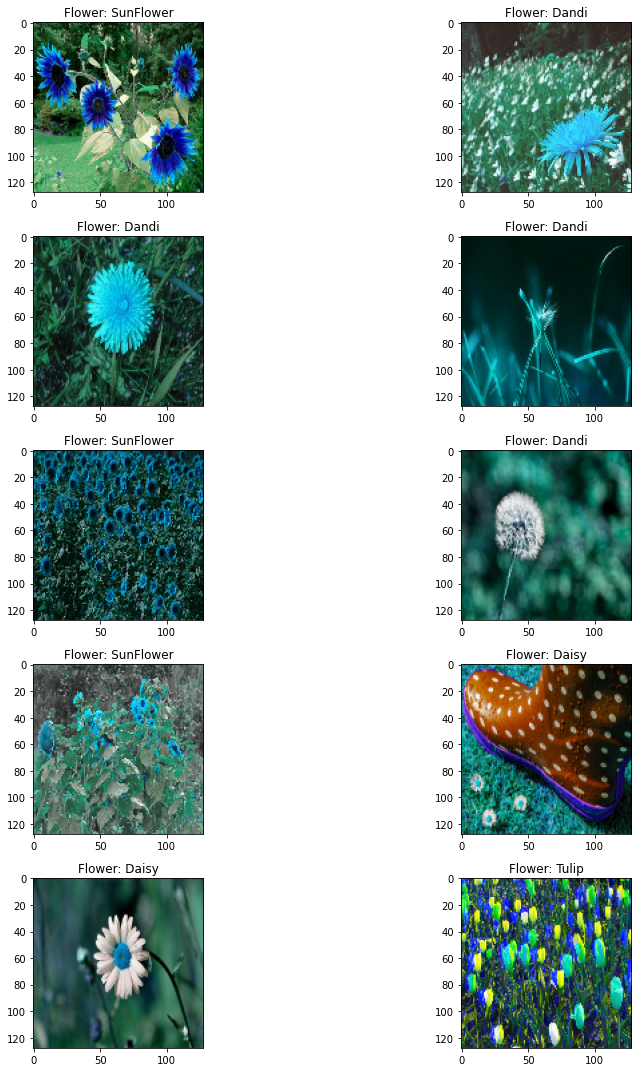

In [7]:
import matplotlib.pyplot as plot
import random

fig,ax=plot.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+labels[l])
        
plot.tight_layout()

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
Y = to_categorical(labels,5)
print(Y)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [9]:
#split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

Modelling

In [10]:
import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', 
                        input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    keras.layers.Conv2D(filters=32, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=128, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
                  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

In [ ]:
tf.debugging.set_log_device_placement(True)
model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=20)


In [ ]:
model.save('deployment/model.tf')